<a href="https://colab.research.google.com/github/aritejhg/APS360-Labs/blob/main/Lab_2_Cats_vs_Dogs_Winter_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 2: Cats vs Dogs

**Deadline**: Feb 07, 5:00pm

**Late Penalty**: There is a penalty-free grace period of one hour past the deadline. Any work that is submitted between 1 hour and 24 hours past the deadline will receive a 20% grade deduction. No other late work is accepted. Quercus submission time will be used, not your local computer time. You can submit your labs as many times as you want before the deadline, so please submit often and early.

**Marking TA**: Saba Ale Ebrahim -- saba.aleebrahim@mail.utoronto.ca

This lab is partially based on an assignment developed by Prof. Jonathan Rose and Harris Chan.

In this lab, you will train a convolutional neural network to classify an image 
into one of two classes: "cat" or "dog". The code for the neural networks 
you train will be written for you, and you are not (yet!) expected
to understand all provided code. However, by the end of the lab,
you should be able to:

1. Understand at a high level the training loop for a machine learning model.
2. Understand the distinction between training, validation, and test data.
3. The concepts of overfitting and underfitting.
4. Investigate how different hyperparameters, such as learning rate and batch size, affect the success of training.
5. Compare an ANN (aka Multi-Layer Perceptron) with a CNN.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission. 

With Colab, you can export a PDF file using the menu option
`File -> Print` and save as PDF file. **Adjust the scaling to ensure that the text is not cutoff at the margins.**

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1sdJ4AxYp8gppkHEnAVPmIgL7tW6hl8HC?usp=sharing

In [ ]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms


## Part 0. Helper Functions

We will be making use of the following helper functions. You will be asked to look
at and possibly modify some of these, but you are not expected to understand all of them.

You should look at the function names and read the docstrings. If you are curious, come back and explore the code *after* making some progress on the lab.

In [ ]:
###############################################################################
# Data Loading

def get_relevant_indices(dataset, classes, target_classes):
    """ Return the indices for datapoints in the dataset that belongs to the
    desired target classes, a subset of all possible classes.

    Args:
        dataset: Dataset object
        classes: A list of strings denoting the name of each class
        target_classes: A list of strings denoting the name of desired classes
                        Should be a subset of the 'classes'
    Returns:
        indices: list of indices that have labels corresponding to one of the
                 target classes
    """
    indices = []
    for i in range(len(dataset)):
        # Check if the label is in the target classes
        label_index = dataset[i][1] # ex: 3
        label_class = classes[label_index] # ex: 'cat'
        if label_class in target_classes:
            indices.append(i)
    return indices

def get_data_loader(target_classes, batch_size):
    """ Loads images of cats and dogs, splits the data into training, validation
    and testing datasets. Returns data loaders for the three preprocessed datasets.

    Args:
        target_classes: A list of strings denoting the name of the desired
                        classes. Should be a subset of the argument 'classes'
        batch_size: A int representing the number of samples per batch
    
    Returns:
        train_loader: iterable training dataset organized according to batch size
        val_loader: iterable validation dataset organized according to batch size
        test_loader: iterable testing dataset organized according to batch size
        classes: A list of strings denoting the name of each class
    """

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = (labels - min_val)/(max_val - min_val)
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

## Part 1. Visualizing the Data [7 pt]

We will make use of some of the CIFAR-10 data set, which consists of 
colour images of size 32x32 pixels belonging to 10 categories. You can
find out more about the dataset at https://www.cs.toronto.edu/~kriz/cifar.html

For this assignment, we will only be using the cat and dog categories. 
We have included code that automatically downloads the dataset the 
first time that the main script is run.

In [ ]:
# This will download the CIFAR-10 dataset to a folder called "data"
# the first time you run this code.
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=1) # One image per batch

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Part (a) -- 1 pt

Visualize some of the data by running the code below.
Include the visualization in your writeup.

(You don't need to submit anything else.)

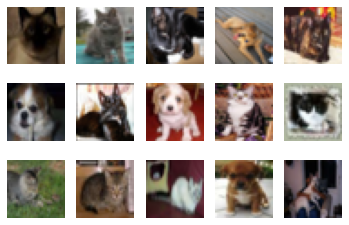

In [ ]:
import matplotlib.pyplot as plt

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(3, 5, k+1)
    plt.axis('off')
    plt.imshow(img)

    k += 1
    if k > 14:
        break

Using this code, we are able to generate a visualization of 15 images contained in the dataset.

### Part (b) -- 3 pt

How many training examples do we have for the combined `cat` and `dog` classes? 
What about validation examples? 
What about test examples?

In [ ]:
#get training and val examples 
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=False)
relevant_indices = get_relevant_indices(trainset, classes, target_classes=["cat", "dog"])
print(len(relevant_indices))
#Get testing examples
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=False)
relevant_test_indices = get_relevant_indices(testset, classes, target_classes=["cat", "dog"])
print(len(relevant_test_indices))

10000
2000


Given that get_data_loader splits the dataset into 80% for training and 20% for validation, there are 8000 training examples, 2000 validation examples, and 2000 testing examples for the cat and dog classes.

### Part (c) -- 3pt

Why do we need a validation set when training our model? What happens if we judge the 
performance of our models using the training set loss/error instead of the validation
set loss/error?

Validation set us a dataset which is not used by the model for training. This allows us to track the actual progress of the model and ensure that model is not memorizing the images or overfitting, as continuous training on the train dataset will result in that. Therefore, validation set provides a new, unseen dataset for the model to evaluate itself on to check how the model performs on new, unseen data.

 Using the training set loss/error will not allow us to know when the model is overfitting, therefore using validation set loss/error is a better metric.

## Part 2. Training [15 pt]

We define two neural networks, a `LargeNet` and `SmallNet`.
We'll be training the networks in this section.

You won't understand fully what these networks are doing until
the next few classes, and that's okay. For this assignment, please
focus on learning how to train networks, and how hyperparameters affect
training.

In [ ]:
class LargeNet(nn.Module):
    def __init__(self):
        super(LargeNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(3, 5, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(5, 10, 5)
        self.fc1 = nn.Linear(10 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 10 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(5 * 7 * 7, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 5 * 7 * 7)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [ ]:
small_net = SmallNet()
large_net = LargeNet()

### Part (a) -- 2pt

The methods `small_net.parameters()` and `large_net.parameters()`
produces an iterator of all the trainable parameters of the network.
These parameters are torch tensors containing many scalar values. 

We haven't learned how how the parameters in these high-dimensional
tensors will be used, but we should be able to count the number
of parameters. Measuring the number of parameters in a network is
one way of measuring the "size" of a network.

What is the total number of parameters in `small_net` and in
`large_net`? (Hint: how many numbers are in each tensor?)

In [ ]:
params = 0
for param in small_net.parameters():
    print(param.shape)
    params+=sum([*param.shape])
print(params)

torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 245])
torch.Size([1])
266


Therefore, small_net has 266 parameters

In [ ]:
params_large = 0
for param in large_net.parameters():
    print(param.shape)
    params_large+=sum([*param.shape])
print(params_large)

torch.Size([5, 3, 5, 5])
torch.Size([5])
torch.Size([10, 5, 5, 5])
torch.Size([10])
torch.Size([32, 250])
torch.Size([32])
torch.Size([1, 32])
torch.Size([1])
406


Therefore, large_net has 406 parameters

### The function train_net

The function `train_net` below takes an untrained neural network (like `small_net` and `large_net`) and
several other parameters. You should be able to understand how this function works.
The figure below shows the high level training loop for a machine learning model:

![alt text](https://github.com/UTNeural/Lab2/blob/master/Diagram.png?raw=true)

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.01, num_epochs=30):
    ########################################################################
    # Train a classifier on cats vs dogs
    target_classes = ["cat", "dog"]
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader, classes = get_data_loader(
            target_classes, batch_size)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

### Part (b) -- 1pt

The parameters to the function `train_net` are hyperparameters of our neural network.
We made these hyperparameters easy to modify so that we can tune them later on. 

What are the default values of the parameters `batch_size`, `learning_rate`, 
and `num_epochs`?

The default parameters passed for `train_net` are `batch_size` 64, `learning_rate` as 0.01 and `num_epochs` as 30.

### Part (c) -- 3 pt

What files are written to disk when we call `train_net` with `small_net`, and train for 5 epochs? Provide a list
of all the files written to disk, and what information the files contain.

In [ ]:
train_net(small_net, num_epochs=5)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6750758628845215 |Validation err: 0.381, Validation loss: 0.6567624937742949
Epoch 2: Train err: 0.364125, Train loss: 0.6410153613090516 |Validation err: 0.358, Validation loss: 0.6479106582701206
Epoch 3: Train err: 0.346875, Train loss: 0.6264904537200928 |Validation err: 0.3535, Validation loss: 0.6260601598769426
Epoch 4: Train err: 0.340375, Train loss: 0.6147777757644654 |Validation err: 0.358, Validation loss: 0.6305410377681255
Epoch 5: Train err: 0.3285, Train loss: 0.6056025924682618 |Validation err: 0.3355, Validation loss: 0.6164079811424017
Finished Training
Total time elapsed: 16.82 seconds


In [ ]:
small_net.state_dict()

OrderedDict([('conv.weight', tensor([[[[ 0.0520,  0.1261,  0.2214],
                        [ 0.0822,  0.2528,  0.2034],
                        [ 0.1145,  0.0928, -0.1261]],
              
                       [[ 0.1303,  0.0890,  0.0812],
                        [-0.1064, -0.1597,  0.1138],
                        [ 0.1451, -0.2252, -0.1089]],
              
                       [[ 0.1119,  0.1319,  0.1415],
                        [ 0.0794, -0.2457, -0.0803],
                        [ 0.1114,  0.0921, -0.1718]]],
              
              
                      [[[-0.2402, -0.0210,  0.0276],
                        [ 0.0571,  0.2263, -0.1024],
                        [-0.0768, -0.0442, -0.1598]],
              
                       [[-0.0872, -0.0540,  0.0161],
                        [ 0.2218,  0.0404,  0.0044],
                        [-0.0333, -0.0537, -0.0755]],
              
                       [[-0.1229, -0.1310, -0.0312],
                        [ 0.3014,  0.0464

FC layers are the fully connected layers, whereas conv layers are the convolutional layers. The state_dict function is used to store information for each epoch's weights and biases.

There are 9 files saved to disk:


*   model_small_bs64_lr0.01_epoch0: Contains the conv.weight, conv.bias, fc.weight, and fc.bias for epoch 0
*   model_small_bs64_lr0.01_epoch1: Contains the conv.weight, conv.bias, fc.weight, and fc.bias for epoch 1
*model_small_bs64_lr0.01_epoch2: Contains the conv.weight, conv.bias, fc.weight, and fc.bias for epoch 2
*model_small_bs64_lr0.01_epoch3: Contains the conv.weight, conv.bias, fc.weight, and fc.bias for epoch 3
*model_small_bs64_lr0.01_epoch4: Contains the conv.weight, conv.bias, fc.weight, and fc.bias for epoch 4
*model_small_bs64_lr0.01_epoch4_train_err.csv: Contains the training error across 5 epochs
*model_small_bs64_lr0.01_epoch4_train_loss.csv: Contains the training loss across 5 epochs
*model_small_bs64_lr0.01_epoch4_val_err.csv: Contains the validation error across 5 epochs
*model_small_bs64_lr0.01_epoch4_val_loss.csv: Contains the validation loss across 5 epochs


### Part (d) -- 2pt

Train both `small_net` and `large_net` using the function `train_net` and its default parameters.
The function will write many files to disk, including a model checkpoint (saved values of model weights) 
at the end of each epoch.

If you are using Google Colab, you will need to mount Google Drive 
so that the files generated by `train_net` gets saved. We will be using
these files in part (d).
(See the Google Colab tutorial for more information about this.)

Report the total time elapsed when training each network. Which network took longer to train?
Why?

In [ ]:
# Since the function writes files to disk, you will need to mount
# your Google Drive. If you are working on the lab locally, you
# can comment out this code.

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
start = time.time()
train_net(small_net)
print (time.time() - start)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.313375, Train loss: 0.5851677360534668 |Validation err: 0.3295, Validation loss: 0.6039913035929203
Epoch 2: Train err: 0.304125, Train loss: 0.579349128484726 |Validation err: 0.3225, Validation loss: 0.6045217551290989
Epoch 3: Train err: 0.299625, Train loss: 0.5745228633880616 |Validation err: 0.3155, Validation loss: 0.5954840499907732
Epoch 4: Train err: 0.3025, Train loss: 0.570121267080307 |Validation err: 0.3215, Validation loss: 0.5954622840508819
Epoch 5: Train err: 0.29225, Train loss: 0.5653520646095276 |Validation err: 0.3175, Validation loss: 0.595168724656105
Epoch 6: Train err: 0.292, Train loss: 0.5597391929626465 |Validation err: 0.3065, Validation loss: 0.5956208128482103
Epoch 7: Train err: 0.294375, Train loss: 0.5618303542137146 |Validation err: 0.3095, Validation loss: 0.5870763752609491
Epoch 8: Train err: 0.285875, Train loss: 0.5549165761470795 |Validation err: 0

In [ ]:
start_large = time.time()
train_net(large_net)
print(time.time()-start_large)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4075, Train loss: 0.6673969159126282 |Validation err: 0.3815, Validation loss: 0.6548288445919752
Epoch 2: Train err: 0.3745, Train loss: 0.6470120940208435 |Validation err: 0.3795, Validation loss: 0.65213025175035
Epoch 3: Train err: 0.359375, Train loss: 0.6318471388816833 |Validation err: 0.35, Validation loss: 0.6274589374661446
Epoch 4: Train err: 0.339375, Train loss: 0.6148322057723999 |Validation err: 0.3315, Validation loss: 0.6161535605788231
Epoch 5: Train err: 0.324125, Train loss: 0.6030768070220948 |Validation err: 0.3295, Validation loss: 0.6144290827214718
Epoch 6: Train err: 0.31875, Train loss: 0.5921280546188354 |Validation err: 0.3195, Validation loss: 0.6050618831068277
Epoch 7: Train err: 0.306625, Train loss: 0.5809661266803742 |Validation err: 0.321, Validation loss: 0.5973013266921043
Epoch 8: Train err: 0.302, Train loss: 0.5713270502090454 |Validation err: 0.304

The time taken for small_net model is 104.93s, whereas the large_net model takes 113.85s. Therefore, large_net takes a longer time to train as it has 1 extra set of layers, which includes a convolutional and an activation layer. Secondly, the convolutional layers in large_net are bigger, which can contribute to the increased runtime as well.

### Part (e) - 2pt

Use the function `plot_training_curve` to display the trajectory of the 
training/validation error and the training/validation loss.
You will need to use the function `get_model_name` to generate the
argument to the `plot_training_curve` function.

Do this for both the small network and the large network. Include both plots
in your writeup.

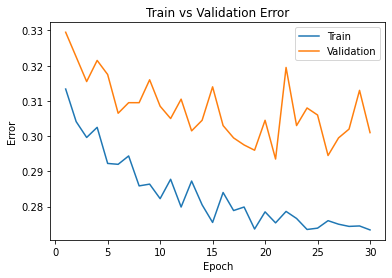

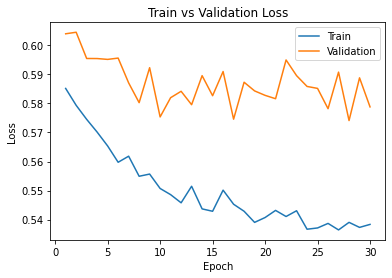

In [ ]:
#model_path = get_model_name("small", batch_size=??, learning_rate=??, epoch=29)
small_model = get_model_name("small", 64, 0.01, 29)
plot_training_curve(small_model)

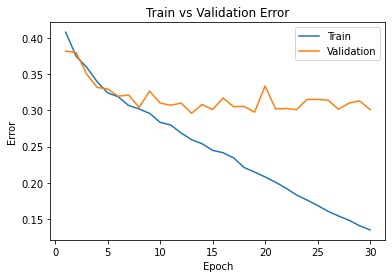

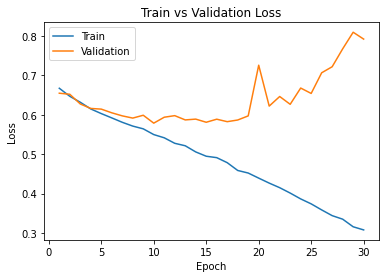

In [ ]:
large_model = get_model_name("large", 64, 0.01, 29)
plot_training_curve(large_model)

### Part (f) - 5pt

Describe what you notice about the training curve.
How do the curves differ for `small_net` and `large_net`?
Identify any occurences of underfitting and overfitting.

We observe that the small_net graph is more jagged and changes drastically epoch to epoch as compared to the graph from large_net. 

While the best performance achieved on the validation by both models looks similar, the large_net model starts overfitting, which is showcased by the increasing difference between training and validation loss and an increase in validation loss, as compared to the small_net graph where both are still decreasing. 

## Part 3. Optimization Parameters [12 pt]

For this section, we will work with `large_net` only.

### Part (a) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.001`.
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *lowering* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.47625, Train loss: 0.6928360013961792 |Validation err: 0.467, Validation loss: 0.6924686580896378
Epoch 2: Train err: 0.448625, Train loss: 0.6922589712142945 |Validation err: 0.4305, Validation loss: 0.691649341955781
Epoch 3: Train err: 0.43575, Train loss: 0.6916067280769348 |Validation err: 0.4285, Validation loss: 0.690854424610734
Epoch 4: Train err: 0.43, Train loss: 0.690861343383789 |Validation err: 0.424, Validation loss: 0.6896595880389214
Epoch 5: Train err: 0.434125, Train loss: 0.6899195008277893 |Validation err: 0.4195, Validation loss: 0.6886935643851757
Epoch 6: Train err: 0.43575, Train loss: 0.6887411961555481 |Validation err: 0.4195, Validation loss: 0.6867824867367744
Epoch 7: Train err: 0.437125, Train loss: 0.6873774147033691 |Validation err: 0.4185, Validation loss: 0.6851982977241278
Epoch 8: Train err: 0.4375, Train loss: 0.6859278454780579 |Validation err: 0.412,

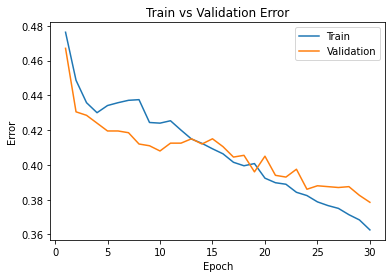

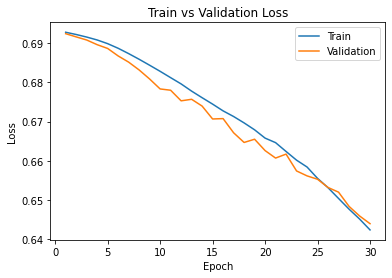

In [ ]:
# Note: When we re-construct the model, we start the training
# with *random weights*. If we omit this code, the values of
# the weights will still be the previously trained values.
large_net = LargeNet()
train_net(large_net, learning_rate = 0.001)
large_model = get_model_name("large", 64, 0.001, 29)
plot_training_curve(large_model)

Using a learning rate of 0.001, we observe that it takes 2.5s longer to train than the learning rate of 0.01. However, this is unlikely to be caused by the learning rate, as the difference is about 2%, which could be due to computation being performed on Google Colab or many other factors. 

Lower learning rate means the speed at which the model learns is slower. Due to learning slower, the model may take more epochs to reach its best accuracy level.

### Part (b) - 3pt

Train `large_net` with all default parameters, except set `learning_rate=0.1`. 
Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the learning rate.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.4295, Train loss: 0.67437779712677 |Validation err: 0.3595, Validation loss: 0.6350857093930244
Epoch 2: Train err: 0.36075, Train loss: 0.6411805458068848 |Validation err: 0.3535, Validation loss: 0.6361209936439991
Epoch 3: Train err: 0.365125, Train loss: 0.6321813461780548 |Validation err: 0.3385, Validation loss: 0.6056603882461786
Epoch 4: Train err: 0.352625, Train loss: 0.6233456182479858 |Validation err: 0.3575, Validation loss: 0.6362800188362598
Epoch 5: Train err: 0.34075, Train loss: 0.6108013873100281 |Validation err: 0.3305, Validation loss: 0.6064918786287308
Epoch 6: Train err: 0.323375, Train loss: 0.5921835997104645 |Validation err: 0.317, Validation loss: 0.5967769594863057
Epoch 7: Train err: 0.3145, Train loss: 0.5817317583560944 |Validation err: 0.3365, Validation loss: 0.6204487886279821
Epoch 8: Train err: 0.29825, Train loss: 0.5660300073623658 |Validation err: 0.

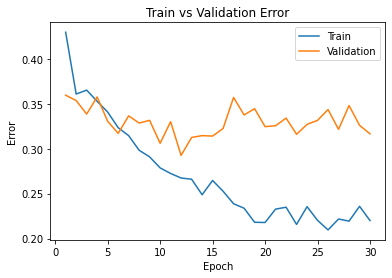

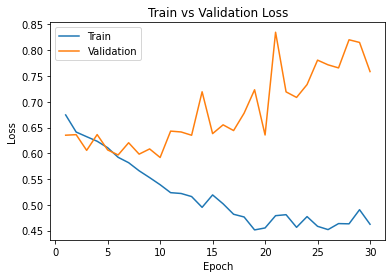

In [ ]:
large_net = LargeNet()
train_net(large_net, learning_rate = 0.1)
large_model = get_model_name("large", 64, 0.1, 29)
plot_training_curve(large_model)

Using learning rate of 0.1 took 2.4s lesser than at learning rate of 0.01. However, this is unlikely to be caused by the learning rate, as the difference is about 2%, which could be due to computation being performed on Google Colab or many other factors.

Higher learning rate means the model tries to learn faster by making more drastic changes, which gives a more jagged result. The performance jumps all over the plave, and validation loss actually increases as the model reached its best performave around epoch 10 and starts to overfit. Lastly, the model could skip past the valley of gradient descent where the best performance lies at a high learning rate. 


### Part (c) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=512`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *increasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.48175, Train loss: 0.6929379552602768 |Validation err: 0.478, Validation loss: 0.6926824003458023
Epoch 2: Train err: 0.457625, Train loss: 0.6924104019999504 |Validation err: 0.434, Validation loss: 0.6917425245046616
Epoch 3: Train err: 0.437, Train loss: 0.6916500590741634 |Validation err: 0.4265, Validation loss: 0.6909129917621613
Epoch 4: Train err: 0.433625, Train loss: 0.6908449940383434 |Validation err: 0.424, Validation loss: 0.6897870451211929
Epoch 5: Train err: 0.434, Train loss: 0.6896935552358627 |Validation err: 0.424, Validation loss: 0.6881355047225952
Epoch 6: Train err: 0.438, Train loss: 0.688353206962347 |Validation err: 0.4285, Validation loss: 0.686011865735054
Epoch 7: Train err: 0.439375, Train loss: 0.6866871677339077 |Validation err: 0.426, Validation loss: 0.6836968809366226
Epoch 8: Train err: 0.43525, Train loss: 0.6849770769476891 |Validation err: 0.4115, Va

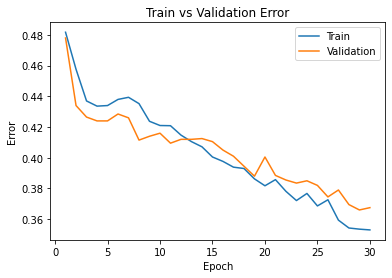

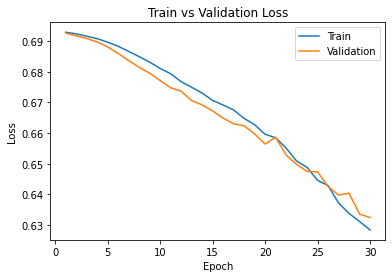

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 512, learning_rate = 0.01)
large_model = get_model_name("large", 512, 0.01, 29)
plot_training_curve(large_model)

The batch size of 512 takes 17s lesser than training at batch size 64. This could be due to parallel processing pf bigger batch sizes, as the total number of batches the model needs to go through decreases while still maintaining time taken per batch. An increased batch however leads to slower learning, but a better generalized learning as the validation accuracy tracks train accuracy more closely.

### Part (d) - 3pt

Train `large_net` with all default parameters, including with `learning_rate=0.01`.
Now, set `batch_size=16`. Does the model take longer/shorter to train?
Plot the training curve. Describe the effect of *decreasing* the batch size.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.43175, Train loss: 0.6774994022846222 |Validation err: 0.382, Validation loss: 0.6513170118331909
Epoch 2: Train err: 0.369, Train loss: 0.639639899969101 |Validation err: 0.3465, Validation loss: 0.6161113576889038
Epoch 3: Train err: 0.34375, Train loss: 0.6098222947120666 |Validation err: 0.3325, Validation loss: 0.6260210764408112
Epoch 4: Train err: 0.314375, Train loss: 0.5849691489338875 |Validation err: 0.34, Validation loss: 0.6044013917446136
Epoch 5: Train err: 0.301125, Train loss: 0.5689119303822517 |Validation err: 0.3125, Validation loss: 0.576918310880661
Epoch 6: Train err: 0.281, Train loss: 0.5452213581204415 |Validation err: 0.308, Validation loss: 0.5708447456359863
Epoch 7: Train err: 0.270875, Train loss: 0.5272981298565864 |Validation err: 0.307, Validation loss: 0.5854293291568756
Epoch 8: Train err: 0.259375, Train loss: 0.5070905526578426 |Validation err: 0.313, 

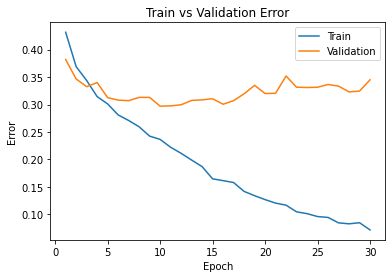

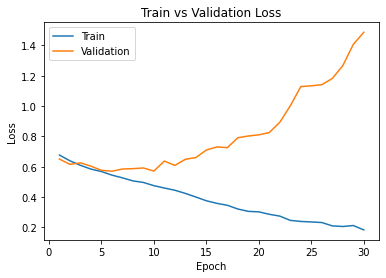

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 16, learning_rate = 0.01)
large_model = get_model_name("large", 16, 0.01, 29)
plot_training_curve(large_model)

The training takes longer by 52s compared to default in this configuration, as the model has to process more batches overall. The model learns faster and started overfitting by epoch 10.

## Part 4. Hyperparameter Search [6 pt]

### Part (a) - 2pt

Based on the plots from above, choose another set of values for the hyperparameters (network, batch_size, learning_rate)
that you think would help you improve the validation accuracy. Justify your choice.

I chose a batch size of 32 and 0.005 for learning rate on the large network. This is because I wanted to decrease learning rate to allow model more time to converge to a more accurate solution. A reduced batch size and learning rate allow model to learn more slowly. However, this is not reduced to learning rate of 0.001 or batch size 16 as we observe these changes can lead to underfitting. 

### Part (b) - 1pt

Train the model with the hyperparameters you chose in part(a), and include the training curve.

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 32, learning_rate = 0.005)


Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.485875, Train loss: 0.6924185979366303 |Validation err: 0.4455, Validation loss: 0.6895165471803575
Epoch 2: Train err: 0.43925, Train loss: 0.6855508913993835 |Validation err: 0.443, Validation loss: 0.6851696996461778
Epoch 3: Train err: 0.412125, Train loss: 0.6746987929344177 |Validation err: 0.385, Validation loss: 0.659080908412025
Epoch 4: Train err: 0.39, Train loss: 0.6586610240936279 |Validation err: 0.4355, Validation loss: 0.668730928784325
Epoch 5: Train err: 0.37025, Train loss: 0.6416938285827637 |Validation err: 0.3525, Validation loss: 0.6301137502231295
Epoch 6: Train err: 0.35125, Train loss: 0.6230331351757049 |Validation err: 0.3555, Validation loss: 0.6337678668990968
Epoch 7: Train err: 0.340625, Train loss: 0.6134937965869903 |Validation err: 0.334, Validation loss: 0.6130238265272171
Epoch 8: Train err: 0.327, Train loss: 0.5998617899417877 |Validation err: 0.3275,

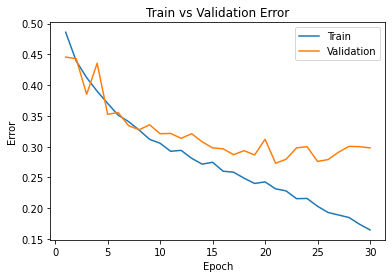

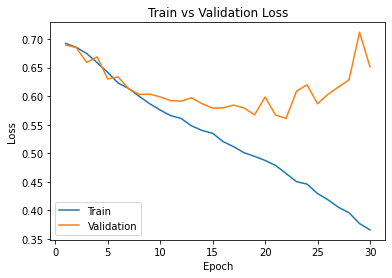

In [ ]:
large_model = get_model_name("large", 32, 0.005, 29)
plot_training_curve(large_model)

### Part (c) - 2pt

Based on your result from Part(a), suggest another set of hyperparameter values to try. 
Justify your choice.

I use a larger batch size of 128. This is because while the learning rate is good and overfitting reduced, the performance still diverges greatly at the end. A higher batch size would allow for better general learning at a slower pace.

### Part (d) - 1pt

Train the model with the hyperparameters you chose in part(c), and include the training curve.

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.466625, Train loss: 0.6925613236805749 |Validation err: 0.4305, Validation loss: 0.6916250362992287
Epoch 2: Train err: 0.45025, Train loss: 0.6910346017943488 |Validation err: 0.4295, Validation loss: 0.6889704614877701
Epoch 3: Train err: 0.4305, Train loss: 0.6885886050405956 |Validation err: 0.4165, Validation loss: 0.6850010603666306
Epoch 4: Train err: 0.430625, Train loss: 0.6850024423901997 |Validation err: 0.4125, Validation loss: 0.6797147057950497
Epoch 5: Train err: 0.420875, Train loss: 0.6813881851377941 |Validation err: 0.411, Validation loss: 0.6762721762061119
Epoch 6: Train err: 0.415875, Train loss: 0.6773001438095456 |Validation err: 0.4125, Validation loss: 0.672969501465559
Epoch 7: Train err: 0.405, Train loss: 0.6732292080682422 |Validation err: 0.4055, Validation loss: 0.6696001030504704
Epoch 8: Train err: 0.4, Train loss: 0.6694153556748043 |Validation err: 0.402

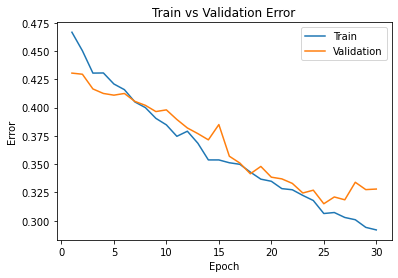

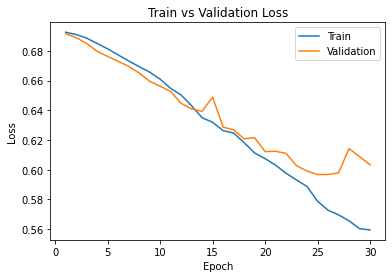

In [ ]:
large_net = LargeNet()
train_net(large_net, batch_size = 128, learning_rate = 0.005)
large_model = get_model_name("large", 128, 0.005, 29)
plot_training_curve(large_model)

## Part 4. Evaluating the Best Model [15 pt]


### Part (a) - 1pt

Choose the **best** model that you have so far. This means choosing the best model checkpoint,
including the choice of `small_net` vs `large_net`, the `batch_size`, `learning_rate`, 
**and the epoch number**.

Modify the code below to load your chosen set of weights to the model object `net`.

Performance of some of the models by (batch size, learning rate) is given below


32, 0.005

Epoch 21: Train err: 0.2315, Train loss: 0.4786718016862869 |Validation err: 0.273, Validation loss: 0.5668698279630571

128,0.005

Epoch 25: Train err: 0.306375, Train loss: 0.5787286261717478 |Validation err: 0.315, Validation loss: 0.596717856824398

16, 0.01

Epoch 10: Train err: 0.236375, Train loss: 0.4756101597249508 |Validation err: 0.297, Validation loss: 0.5718690166473389

default small

Epoch 21: Train err: 0.275375, Train loss: 0.5431575722694397 |Validation err: 0.2935, Validation loss: 0.5816235858947039

default large

Epoch 13: Train err: 0.259625, Train loss: 0.5213688533306122 |Validation err: 0.296, Validation loss: 0.5870076389983296

64, 0.1

Epoch 12: Train err: 0.267375, Train loss: 0.5220149435997009 |Validation err: 0.2925, Validation loss: 0.6413561534136534


The best performance is observed by using the LargeNet model with a batch size of 64 and learning rate of 0.1

Epoch 12: Train err: 0.267375, Train loss: 0.5220149435997009 |Validation err: 0.2925, Validation loss: 0.6413561534136534

In [ ]:
net = LargeNet()
model_path = get_model_name(net.name, batch_size=32, learning_rate=0.005, epoch=21)
state = torch.load(model_path)
net.load_state_dict(state)

<All keys matched successfully>

### Part (b) - 2pt

Justify your choice of model from part (a).

The model is chosen as it gives the best accuracy on the validation set.

### Part (c) - 2pt

Using the code in Part 0, any code from lecture notes, or any code that you write,
compute and report the **test classification error** for your chosen model.

In [ ]:
# If you use the `evaluate` function provided in part 0, you will need to 
# set batch_size > 1
train_loader, val_loader, test_loader, classes = get_data_loader(
    target_classes=["cat", "dog"], 
    batch_size=32)

test_err, test_loss = evaluate(net,test_loader,nn.BCEWithLogitsLoss())
print(f'Test error: {test_err}, \nTest loss: {test_loss}')


Files already downloaded and verified
Files already downloaded and verified
Test error: 0.2875, 
Test loss: 0.5607681894113147


### Part (d) - 3pt

How does the test classification error compare with the **validation error**?
Explain why you would expect the test error to be *higher* than the validation error.

In [ ]:
val_err, val_loss = evaluate(net,val_loader,nn.BCEWithLogitsLoss())
print(f'Validation error: {val_err}, \nValidation loss: {val_loss}')


Validation error: 0.2795, 
Validation loss: 0.5630016251215859


The test error is slightly higher than validation error, as the network has worked to reduce the error rate on the validation set and has "seen" it before even though it has not trained on it before. However, test set comprises of completely new data for the model, which would give slightly higer error rate. 

### Part (e) - 2pt

Why did we only use the test data set at the very end?
Why is it important that we use the test data as little as possible?

This is important to evaluate model's performance on a completely unseen data, to simulate real-world where it would be seeing previously unseen data. The validation set does have some impact on the training of the model, which is why to get an unbiased result we use the test set only once at the end.

### Part (f) - 5pt

How does the your best CNN model compare with an 2-layer ANN model (no convolutional layers) on classifying cat and dog images. You can use a 2-layer ANN architecture similar to what you used in Lab 1. You should explore different hyperparameter settings to determine how well you can do on the validation dataset. Once satisified with the performance, you may test it out on the test data.

Hint: The ANN in lab 1 was applied on greyscale images. The cat and dog images are colour (RGB) and so you will need to flatted and concatinate all three colour layers before feeding them into an ANN.

In [ ]:
def data_loader(target_classes, batch_size):

    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    ########################################################################
    # The output of torchvision datasets are PILImage images of range [0, 1].
    # We transform them to Tensors of normalized range [-1, 1].
    # WE ALSO CONVERT IMAGES TO GRAYSCALE HERE USING transforms.Grayscale()
    transform = transforms.Compose(
        [transforms.ToTensor(),transforms.Grayscale(),
         transforms.Normalize((0.5), (0.5))
         ])
    # Load CIFAR10 training data
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_indices = get_relevant_indices(trainset, classes, target_classes)
    
    # Split into train and validation
    np.random.seed(1000) # Fixed numpy random seed for reproducible shuffling
    np.random.shuffle(relevant_indices)
    split = int(len(relevant_indices) * 0.8) #split at 80%
    
    # split into training and validation indices
    relevant_train_indices, relevant_val_indices = relevant_indices[:split], relevant_indices[split:]  
    train_sampler = SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               num_workers=1, sampler=train_sampler)
    val_sampler = SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              num_workers=1, sampler=val_sampler)
    # Load CIFAR10 testing data
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
    # Get the list of indices to sample from
    relevant_test_indices = get_relevant_indices(testset, classes, target_classes)
    test_sampler = SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             num_workers=1, sampler=test_sampler)
    return train_loader, val_loader, test_loader, classes

In [ ]:
def train_net(net, batch_size=32, learning_rate=0.001, num_epochs=30):

    target_classes = ["cat", "dog"]
    torch.manual_seed(1000)

    train_loader, val_loader, test_loader, classes = data_loader(
            target_classes, batch_size)
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)

    start_time = time.time()

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        torch.save(net.state_dict(), model_path)
        
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

In [ ]:
torch.manual_seed(1000)

class CIFAR_ANN(nn.Module):
    def __init__(self):
        super(CIFAR_ANN, self).__init__()
        self.name = "ANN"
        self.layer1 = nn.Linear(32 * 32, 30)
        self.layer2 = nn.Linear(30, 1)
    def forward(self, img):
        flattened = img.view(-1, 32 * 32)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        return activation2.squeeze(1)

In [ ]:
cifar_ann = CIFAR_ANN()
train_net(cifar_ann)

Files already downloaded and verified
Files already downloaded and verified
Epoch 1: Train err: 0.421375, Train loss: 0.6783337914943695 |Validation err: 0.4095, Validation loss: 0.6700394021140205
Epoch 2: Train err: 0.400125, Train loss: 0.6639820146560669 |Validation err: 0.4085, Validation loss: 0.6629212839262826
Epoch 3: Train err: 0.396, Train loss: 0.6566999154090881 |Validation err: 0.4015, Validation loss: 0.6585395232079521
Epoch 4: Train err: 0.391875, Train loss: 0.651263041973114 |Validation err: 0.3975, Validation loss: 0.656681878226144
Epoch 5: Train err: 0.38475, Train loss: 0.6474067733287812 |Validation err: 0.392, Validation loss: 0.65406225314216
Epoch 6: Train err: 0.383125, Train loss: 0.6432377531528473 |Validation err: 0.393, Validation loss: 0.6537558644536942
Epoch 7: Train err: 0.375875, Train loss: 0.6402484629154205 |Validation err: 0.391, Validation loss: 0.6527233965813167
Epoch 8: Train err: 0.3715, Train loss: 0.6373168089389801 |Validation err: 0.398

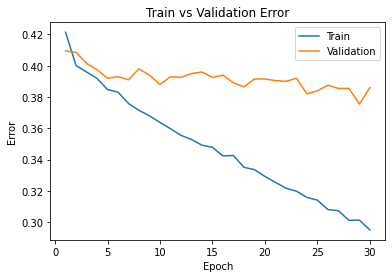

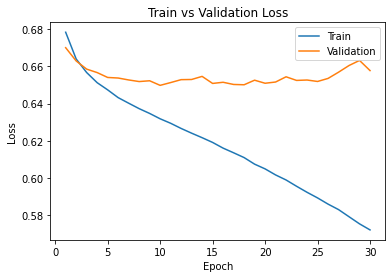

In [ ]:
ann_model = get_model_name("ANN", 32, 0.001, 29)
plot_training_curve(ann_model)

In [ ]:
train_loader, val_loader, test_loader, classes = data_loader(
    target_classes=["cat", "dog"], 
    batch_size=32)

net_ann = CIFAR_ANN()
model_path = get_model_name(net_ann.name, batch_size=32, learning_rate=0.001, epoch=29)
state = torch.load(model_path)
net_ann.load_state_dict(state)

test_err, test_loss = evaluate(net_ann,test_loader,nn.BCEWithLogitsLoss())
print(f'Test error: {test_err}, \nTest loss: {test_loss}\n')

val_err, val_loss = evaluate(net_ann,val_loader,nn.BCEWithLogitsLoss())
print(f'Validation error: {val_err}, \nValidation loss: {val_loss}')

Files already downloaded and verified
Files already downloaded and verified
Test error: 0.367, 
Test loss: 0.646263009025937

Validation error: 0.386, 
Validation loss: 0.6574822238513401


The ANN model therefore performs worse than the CNN model.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Lab_2_Cats_vs_Dogs_Winter_2022.ipynb

[NbConvertApp] Converting notebook /content/Lab_2_Cats_vs_Dogs_Winter_2022.ipynb to html
[NbConvertApp] Writing 1021099 bytes to /content/Lab_2_Cats_vs_Dogs_Winter_2022.html
